### *Localisation optimale des capacités de production éoliennes en Europe*

Notebook pour le  chargement des données du projet (partie I) -- version 1.2 (màj le 31/3/2020)

In [1]:
## imports classiques
import numpy as np

from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray, CyLPModel

import matplotlib.pyplot as plt
import math 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.colors as colors
import random


colors_list = list(colors._colors_full_map.values())
random.shuffle(colors_list)

%matplotlib notebook

In [2]:
## paramètres

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

liste_pays_index_dic = {'Allemagne':0,'Autriche':1,'Belgique':2,'Danemark':3,'Espagne':4,'France':5,'Irlande':6,'Italie':7,'Luxembourg':8,\
             'Norvège':9,'Pays-Bas':10,'Portugal':11,'Royaume-Uni':12,'Suède':13,'Suisse':14}

list_colors_dic = {'Allemagne':colors_list[0],'Autriche':colors_list[1],'Belgique':colors_list[2],'Danemark':colors_list[3],'Espagne':colors_list[4],\
                         'France':colors_list[5],'Irlande':colors_list[6],'Italie':colors_list[7],'Luxembourg':colors_list[8],\
             'Norvège':colors_list[9],'Pays-Bas':colors_list[10],'Portugal':colors_list[11],'Royaume-Uni':colors_list[12],'Suède':colors_list[13],'Suisse':colors_list[14]} 

TURB = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
POMP = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])
RES = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

N_pays = 15                  # plus petit ou égal à N_pays_max = 15
N_sites = 642                # plus petit ou égal à sites_max = 642
N_heures_par_annee = 24*365  # nombre d'heures par année
N_annees = 1/12              # fraction de l'annee à utiliser ; prendre par exemple 1/12 pour tester sur un mois (calculs 
                             # plus rapides) ; dans le rapport il faut utiliser l'année complète N_annees = 1
#N_heures = int(np.ceil(N_heures_par_annee*N_annees)) # nombre d'heures à extraire des fichiers de rendements
N_heures =732
vecteur_temps = np.arange(1,N_heures+1) / N_heures_par_annee

In [3]:
## chargement et traitement des données brutes (I)
 
sites = pd.read_csv('Sites.csv')

onshore = sites[sites['capacite offshore']=='Non'].copy()
offshore = sites[sites['capacite offshore']=='Oui'].copy()

In [4]:
sites.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
0,1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
1,2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
2,3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
3,4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,5,54.0,12.0,Allemagne,#7b0323,Non,0.002193,5003.709632


In [5]:
onshore.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
0,1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
1,2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
2,3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
3,4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,5,54.0,12.0,Allemagne,#7b0323,Non,0.002193,5003.709632


In [6]:
offshore.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
487,0,54.0,7.0,Allemagne,#7b0323,Oui,0.006342,8364.150000
488,48,56.0,5.0,Danemark,#A9A9A9,Oui,0.010571,15478.589744
489,49,55.0,6.0,Allemagne,#7b0323,Oui,0.010571,13940.250000
490,61,52.0,3.0,Pays-Bas,#04d8b2,Oui,0.006342,2349.264706
491,66,58.0,10.0,Suède,#758da3,Oui,0.006342,8577.125000


In [7]:
"""# Visualisations des données pour les sites 

fig = go.Figure(data=go.Scattergeo(
        lon = offshore['longitude'],
        lat = offshore['latitude'],
        text = offshore['pays'],
        mode = 'markers',
        marker=dict(
        color = offshore['couleur'],
        size = offshore['scores']*1000)
        ))

fig.update_layout(
        title = 'Sites offshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"# Visualisations des données pour les sites \n\nfig = go.Figure(data=go.Scattergeo(\n        lon = offshore['longitude'],\n        lat = offshore['latitude'],\n        text = offshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = offshore['couleur'],\n        size = offshore['scores']*1000)\n        ))\n\nfig.update_layout(\n        title = 'Sites offshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [8]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = onshore['longitude'],
        lat = onshore['latitude'],
        text = onshore['pays'],
        mode = 'markers',
        marker=dict(
        color = onshore['couleur'],
        size = onshore['scores']*3000)
        ))

fig.update_layout(
        title = 'Sites onshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = onshore['longitude'],\n        lat = onshore['latitude'],\n        text = onshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = onshore['couleur'],\n        size = onshore['scores']*3000)\n        ))\n\nfig.update_layout(\n        title = 'Sites onshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [9]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = sites['pays'],
        mode = 'markers',
        marker_color = sites['couleur'],
        marker = dict(size = 2),
        ))

fig.update_layout(
        title = 'Affectation par pays des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = sites['pays'],\n        mode = 'markers',\n        marker_color = sites['couleur'],\n        marker = dict(size = 2),\n        ))\n\nfig.update_layout(\n        title = 'Affectation par pays des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [10]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+\
        sites['capacites'].astype(str),
        mode = 'markers',
        marker = dict(
            color = sites['couleur'],
            size = sites['capacites']/sites['capacites'].max() * 30)
        ))

fig.update_layout(
        title = 'Capacites des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+        sites['capacites'].astype(str),\n        mode = 'markers',\n        marker = dict(\n            color = sites['couleur'],\n            size = sites['capacites']/sites['capacites'].max() * 30)\n        ))\n\nfig.update_layout(\n        title = 'Capacites des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [11]:
# chargement et traitement des données brutes (II)
rend_offshore_brut = np.genfromtxt('Rendements_offshore.csv', delimiter=',')[:,:N_heures]
rend_onshore_brut = np.genfromtxt('Rendements_onshore.csv', delimiter=',')[:,:N_heures]

print(rend_offshore_brut.shape)
print(rend_onshore_brut.shape)

(642, 732)
(642, 732)


In [12]:
indice_offshore= offshore["index site"]
rend_offshore_matrix = rend_offshore_brut[indice_offshore]
rend_offshore_array = np.array([np.sum(rend_offshore_matrix[i]) for i in range(len(indice_offshore))])


indice_onshore= onshore["index site"]
rend_onshore_matrix = rend_onshore_brut[indice_onshore]
rend_onshore_array = np.array([np.sum(rend_onshore_matrix[i]) for i in range(len(indice_onshore))])

maxoff= max(rend_offshore_array)
maxon = max(rend_onshore_array)

for i in range(len(rend_offshore_array)):
    if (rend_offshore_array[i] == max(rend_offshore_array) ) :
        print("Max offshore = {}  at  index = {} in offshore submatrix".format(maxoff,i))

for i in range(len(rend_onshore_array)):
    if (rend_onshore_array[i] == max(rend_onshore_array) ) : 
        print("Max onshore = {}  at  index = {} in onshore submatrix\n".format(maxon,i))
        
for i in range(642):
    if (rend_offshore_brut[i].sum() == maxoff):
        print("Max offshore = {}  at  index = {} in total matrix".format(maxoff,i))
    elif (rend_onshore_brut[i].sum() == maxon):
        print("Max onshore = {}  at  index = {} in total matrix".format(maxon,i))

Max offshore = 516.527424  at  index = 5 in offshore submatrix
Max onshore = 501.69911360000003  at  index = 62 in onshore submatrix

Max offshore = 516.527424  at  index = 67 in total matrix
Max onshore = 501.69911360000003  at  index = 69 in total matrix


In [13]:
rend_sites_matrix = rend_onshore_brut.copy()   # matrix combinant les valeurs réelles onshore/offshore -> souci de visibilité ci-dessous
for i in np.array(indice_offshore):
    rend_sites_matrix[i] = rend_offshore_brut[i]

print(rend_sites_matrix[443][0] == rend_offshore_brut[443][0])

True


In [17]:
#version pour le projet
#TODO contraince active, variable =0

s = CyClpSimplex()

T = 3 # pas de temps
kappa = 0.17
delta = 0.02


# Add variables
x = s.addVariable('x', N_sites)

# Create coefficients and bounds
P=500000

# Add constraints
s += x >= 0

p_max = CyLPArray(sites["capacites"])        
s += x <= p_max

s += x.sum() == P


offshorearray = np.zeros(N_sites)
offshorearray[indice_offshore] = 1      # set à 1 les sites offshore 
s += (CyLPArray(offshorearray)*x) == kappa*P

n_interval = int(N_heures/T) - 1  # nombre d'intervalle sur les heures imparties
L = s.addVariable('l', n_interval)  # vecteur T de longeur n_interval pour gérer valeurs absolues 
s.addConstraint(L.sum() <= delta*P*n_interval,"variabilité") # contrainte de variabilité

total = np.zeros(N_sites)
#TODO sum 1) sum2
for n in range (n_interval):
    for k in range(N_sites):
        rend1_sum =0
        rend2_sum = 0
        for i in range (T*n, T*n+T):
            rend1_sum += rend_sites_matrix[k][i]
            rend2_sum += rend_sites_matrix[k][i+T]
        total[k] = rend1_sum - rend2_sum
    total= CyLPArray(total)
    s += total*x - L[n] <= 0
    s += -(total*x) - L[n] <= 0



#print ("\nConstraints :\n", s.constraints)
#print ("\nConstraintMatrix :\n", s.coefMatrix)

# Set the objective function
c_off= -CyLPArray(rend_offshore_array)   # rendements associés aux sites offshore
c_on = -CyLPArray(rend_onshore_array)    # rendements associés aux sites onshore

s.objective = c_off * x[np.array(indice_offshore)] + c_on * x[np.array(indice_onshore)]    #n'accepte pas les types : pandas.series
#print("\nc = ",s.objective)

# Solve using primal Simplex
s.primal()

## Solutions ##

PUISSANCE_INSTALLEE = s.primalVariableSolution['x']
ENERGIE_TOTALE = -s.objectiveValue

print ("\nlsol = ",s.primalVariableSolution['l']) 
#print(s.dualConstraintSolution)
print ("\nxsol = ",PUISSANCE_INSTALLEE) 
print("\nObjVal = ", ENERGIE_TOTALE)
print("\nSOL OPTIMALE ? = ", s.getStatusString())
print(s.primalVariableSolution['x'].sum())
print(s.primalVariableSolution['x'][indice_offshore].sum())


lsol =  [ 45483.69243148  27693.03749668 -22891.73415256  20278.68934722
  20472.23224283  45015.79453214  81198.52485156  83187.7381253
  34250.69286246  36894.07113727  66451.53902824  38256.01447975
  11873.80985953    712.33951725  -5884.45506716      0.
 -43495.67680934 -14817.3896216   62827.64499921   -546.17517058
 -91219.07251385 -45591.44356623  31637.09679763  -5663.07869513
 -61344.82604397 -60910.84243439 -64453.78093547 -94893.8232621
 -91440.08154085 -38510.58540976 -12235.23468036  -9513.70404783
 -28034.12475346  17265.83508178  18835.78505032  30321.93019857
  12401.19427526  39831.21951354  25989.67625293  31365.15902585
      0.           -146.03479659  48469.21369415   7057.90585855
      0.          -3843.51086153  63495.09349549  48063.80022291
  -3192.59226685   4722.92024161   2074.90513763  -7158.0094415
 -35584.48501086  -4279.12437676  56400.39328727  32827.51048138
      0.              0.         -15858.30278492  -5760.25877139
   2875.8131003   29667.020

In [21]:
print(s.primalVariableSolution['l'].sum())
print(delta*P*n_interval)
rend_moyen = ENERGIE_TOTALE/(N_heures*500000)
print("Rendement moyen sur une année :", rend_moyen )

1077999.220979281
2430000.0
Rendement moyen sur une année : 0.5277235301274324


In [16]:
#TODO faire un dataframe panda pour classer les 10 meilleurs sites selon leurs rendements moyen sur l'année
#TODO variabilité des best sites (Est -ce que les best sites sont compatible savec la notion de variabilité 
#     ou alor est-ce qu'ils sont tres tres bons sur toutes l'année mais produisent beaucoup de maniere tres instable )

dict = {}
for i in range(len(rend_sites_matrix)):
    dict[i] = rend_sites_matrix[i].sum()

dict_sorted = sorted(dict.items(), key=lambda x: x[1],reverse=True)
dict_best = dict_sorted[:10]

index_best = np.zeros(10)
rendement_best = np.zeros(10)
for i in range(10):
    index_best[i] = dict_best[i][0]
    rendement_best[i]=(dict_best[i][1])/N_heures

classement = pd.DataFrame([],columns = sites.columns)

for i in range(10):
    ligne = sites[sites["index site"]==index_best[i]]
    classement= classement.append(ligne)
del classement["couleur"]
del classement["scores"]
del classement["capacites"]
classement["rendement moyen"] = rendement_best
classement["différence"] = rendement_best - rend_moyen

classement.reset_index(drop=True, inplace=True) 

# Classement des meilleurs sites suivant leur rendement moyen

In [33]:
classement

,index site,latitude,longitude,pays,capacite offshore,rendement moyen,différence
0,67,57.0,6.0,Danemark,Oui,0.705639,0.177915
1,68,57.0,7.0,Danemark,Oui,0.693775,0.166051
2,69,57.0,8.0,Danemark,Non,0.685381,0.157658
3,2,54.0,9.0,Allemagne,Non,0.671455,0.143731
4,408,57.0,5.0,Norvège,Oui,0.662672,0.134949
5,75,56.0,8.0,Danemark,Non,0.661150,0.133427
6,399,58.0,6.0,Norvège,Oui,0.657555,0.129831
7,73,56.0,6.0,Danemark,Oui,0.655823,0.128100
8,74,56.0,7.0,Danemark,Oui,0.655724,0.128001
9,0,54.0,7.0,Allemagne,Oui,0.653835,0.126112


il y a 80 sites éoliens en France


NameError: name 'matrice_rendements_onshore' is not defined

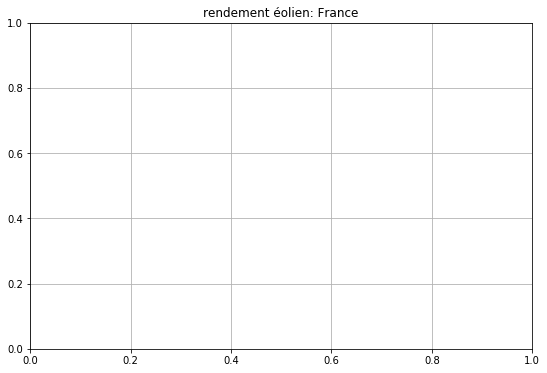

In [34]:
## Visualisation des rendements pour un pays

pays_test = 'France'
index_test = liste_pays_index_dic[pays_test]

# nombre de sites éoliens
index_sites_eoliens = sites[sites.pays==pays_test]['index site']
n_eoliens = len(index_sites_eoliens)
print('il y a '+str(n_eoliens)+' sites éoliens en '+str(pays_test))

# rendements eolien au hasard
random_site = np.random.choice(index_sites_eoliens)
plt.figure(figsize=(9,6))
plt.grid()
plt.title('rendement éolien: '+str(pays_test))
if sites.loc[random_site]['capacite offshore']=='Oui':
    plt.plot(vecteur_temps,matrice_rendements_offshore[random_site])
    plt.legend(['offshore'])
else:
    plt.plot(vecteur_temps,matrice_rendements_onshore[random_site])
    plt.legend(['onshore'])
plt.xlabel('temps : [années]')
plt.ylabel('rendement éolien: [/]')

print('rendement moyen offshore pour le pays: '+str(np.mean(matrice_rendements_offshore[index_sites_eoliens])))
print('rendement moyen onshore pour le pays: '+str(np.mean(matrice_rendements_onshore[index_sites_eoliens])))

# capacité éoliennes maximales tolérables
buf_ok_offshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Oui')
buf_ok_onshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Non')

print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_offshore]['capacites'].sum()))
print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_onshore]['capacites'].sum()))

# latitude/longitude
print('le pays '+str(pays_test)+' se trouve  à une latitude de '+str(sites.loc[random_site]['latitude'])+' et une longitude de '+\
      str(sites.loc[random_site]['longitude']))